## Import essential libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from shapely.geometry import LineString
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import random
import numpy

## Read and process data


- SOG - Speed over ground (knots)
- COG - Course over ground (Degrees)
- Heading - Ship's head direction 

![](https://researchoutreach.org/wp-content/uploads/2019/02/Ship-Heading-300x300.jpg)


Some research done where AIS data was used to prediction:

1. [Forecasting Tsunamis using Ship Navigation Records](https://researchoutreach.org/articles/forecasting-tsunamis/) : *The AIS data obtained from these ships indicated that COG significantly deviates from Ship's Heading as the tsunami passes the ship*

In [2]:
df = pd.read_csv("Data\Bornholmsgat_26_2_2022.csv", parse_dates=[0]) #.iloc[:, :8]
df = df.drop("Trip No.", axis=1)
df = df.sort_values(by="# Timestamp", ascending=True)
df = df[df['Ship type']=='Tanker']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53555 entries, 403 to 581021
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   # Timestamp  53555 non-null  datetime64[ns]
 1   MMSI         53555 non-null  int64         
 2   Latitude     53555 non-null  float64       
 3   Longitude    53555 non-null  float64       
 4   SOG          53555 non-null  float64       
 5   COG          53555 non-null  float64       
 6   Heading      52856 non-null  float64       
 7   IMO          53555 non-null  int64         
 8   Name         53555 non-null  object        
 9   Ship type    53555 non-null  object        
 10  Length       53555 non-null  float64       
 11  Draught      52856 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 5.3+ MB


# Timestamp       MMSI   Latitude  Longitude   SOG    COG  \
403 2022-02-26 00:01:13  636019055  55.724625  15.536187  12.7  238.9   
419 2022-02-26 00:01:16  636019055  55.724353  15.535388  12.6  238.8   
476 2022-02-26 00:01:27  636019055  55.724022  15.534412  12.6  239.0   
531 2022-02-26 00:01:36  636019055  55.723752  15.533612  12.6  239.2   
580 2022-02-26 00:01:45  636019055  55.723452  15.532722  12.6  239.1   

     Heading      IMO             Name Ship type  Length  Draught  
403    237.0  9843572  SAMUEL PROSPECT    Tanker   250.0      9.0  
419    237.0  9843572  SAMUEL PROSPECT    Tanker   250.0      9.0  
476    237.0  9843572  SAMUEL PROSPECT    Tanker   250.0      9.0  
531    237.0  9843572  SAMUEL PROSPECT    Tanker   250.0      9.0  
580    237.0  9843572  SAMUEL PROSPECT    Tanker   250.0      9.0

## Plotting all ships with SAMUS SWAN

Ship that was identified as sailing with dragged anchors due to which it caused damage to the power cable in Bornholm

- Vessel:SAMUS SWAN 
- MMSI: 248363000
- Type: Oil/Chemical Tanker
- IMO: 9401312

In [3]:
## Make paths
## group each ship into LineString paths

def make_paths(ais_df):
    path = {}
    for mmsi, dfx in ais_df.dropna(subset=["Latitude", "Longitude"]).groupby("MMSI"):
        points = list(zip(dfx["Longitude"], dfx["Latitude"]))
        if len(points)>1:
            path[mmsi] = LineString(points)
        else:
            print("Only %d point found for the ship with MMSI: %d" % (len(points), mmsi))
            
    path_gdf = gpd.GeoDataFrame({"MMSI":path.keys(), "geometry": path.values()}, crs="epsg:4326", geometry="geometry")
    return path_gdf

In [4]:
path_gdf = make_paths(df)
path_gdf

MMSI                                           geometry
0   211822000  LINESTRING (14.20394 55.06260, 14.20435 55.062...
1   215402000  LINESTRING (15.87919 55.72467, 15.87811 55.724...
2   215584000  LINESTRING (14.46002 55.26654, 14.46059 55.266...
3   215782000  LINESTRING (14.18835 55.06260, 14.18890 55.062...
4   218057000  LINESTRING (15.42111 55.53382, 15.42111 55.533...
5   219007671  LINESTRING (14.69637 55.09550, 14.69637 55.095...
6   219018272  LINESTRING (15.81403 55.66147, 15.81288 55.661...
7   219029722  LINESTRING (14.20927 55.06282, 14.21008 55.063...
8   236446000  LINESTRING (14.46012 55.06275, 14.45932 55.063...
9   240244000  LINESTRING (15.87995 55.70755, 15.87892 55.707...
10  241192000  LINESTRING (14.40250 55.29817, 14.40183 55.297...
11  244168000  LINESTRING (14.02695 55.15168, 14.02755 55.151...
12  244859000  LINESTRING (15.87932 55.86147, 15.87684 55.860...
13  246694000  LINESTRING (14.21359 55.06321, 14.21396 55.063...
14  248024000  LINESTRING (14.19583 55.06282, 14.19641 55.063...
15  248363000  LINESTRING (15.70040 55.68003, 15.69966 55.679...
16  249803000  LINESTRING (14.18846 55.06284, 14.18912 55.063...
17  249853000  LINESTRING (15.88019 55.71055, 15.87932 55.710...
18  249857000  LINESTRING (14.21499 55.06273, 14.21589 55.063...
19  256764000  LINESTRING (15.87788 55.84900, 15.87726 55.848...
20  257206000  LINESTRING (15.59881 55.76260, 15.59554 55.761...
21  257409000  LINESTRING (14.19651 55.06271, 14.19707 55.063...
22  258915000  LINESTRING (15.88008 55.85015, 15.87753 55.849...
23  259768000  LINESTRING (14.96688 55.39255, 14.96771 55.392...
24  266470000  LINESTRING (15.73243 55.78132, 15.73142 55.780...
25  538005401  LINESTRING (14.02655 55.15201, 14.02740 55.151...
26  636012813  LINESTRING (14.19587 55.06258, 14.19643 55.062...
27  636015737  LINESTRING (14.02684 55.15210, 14.02911 55.152...
28  636019055  LINESTRING (15.53619 55.72463, 15.53539 55.724...
29  636020838  LINESTRING (15.87999 55.71838, 15.87840 55.718...
30  642122020  LINESTRING (14.02706 55.15344, 14.02912 55.153...

In [5]:
df[df["MMSI"]==257206000]

# Timestamp       MMSI   Latitude  Longitude   SOG    COG  \
55575  2022-02-26 02:51:18  257206000  55.762603  15.598805  11.0  245.0   
55610  2022-02-26 02:51:23  257206000  55.761562  15.595542  11.1  238.1   
55673  2022-02-26 02:51:34  257206000  55.761297  15.594760  11.2  238.9   
55720  2022-02-26 02:51:42  257206000  55.761075  15.594045  11.1  241.0   
55790  2022-02-26 02:51:52  257206000  55.760842  15.593242  11.0  242.5   
...                    ...        ...        ...        ...   ...    ...   
207185 2022-02-26 08:52:14  257206000  55.235238  14.031307  10.4  270.2   
207256 2022-02-26 08:52:23  257206000  55.235242  14.030560  10.3  269.8   
207341 2022-02-26 08:52:33  257206000  55.235237  14.029728  10.2  269.5   
207429 2022-02-26 08:52:44  257206000  55.235248  14.028823  10.1  271.2   
207581 2022-02-26 08:53:03  257206000  55.235273  14.027353  10.1  272.0   

        Heading      IMO   Name Ship type  Length  Draught  
55575     241.0  9279410  GERDA    Tanker    82.0      4.8  
55610     240.0  9279410  GERDA    Tanker    82.0      4.8  
55673     242.0  9279410  GERDA    Tanker    82.0      4.8  
55720     243.0  9279410  GERDA    Tanker    82.0      4.8  
55790     244.0  9279410  GERDA    Tanker    82.0      4.8  
...         ...      ...    ...       ...     ...      ...  
207185    273.0  9279410  GERDA    Tanker    82.0      4.8  
207256    273.0  9279410  GERDA    Tanker    82.0      4.8  
207341    274.0  9279410  GERDA    Tanker    82.0      4.8  
207429    274.0  9279410  GERDA    Tanker    82.0      4.8  
207581    275.0  9279410  GERDA    Tanker    82.0      4.8  

[2053 rows x 12 columns]

In [6]:
r = lambda: random.randint(0,255)
color = lambda : '#%02X%02X%02X' % (r(),r(),r())

def line_style(x):
    return {
        "opacity": 1 if x["properties"]["MMSI"] == 257206000 else 0.1,
        "color": "red" if x["properties"]["MMSI"] == 257206000 else "blue"
    }

In [7]:
%%time
route_map = folium.Map(location = (55.14909, 14.879))

for mmsi in tqdm(path_gdf["MMSI"]):
    x = path_gdf[path_gdf["MMSI"]==mmsi]
    x = x.to_json()
    folium.GeoJson(x, tooltip="MMSI: %d" % mmsi, style_function=line_style).add_to(route_map)

route_map

  0%|          | 0/31 [00:00<?, ?it/s]

Wall time: 638 ms


## Timeseries comparison

In [8]:
x = df[["MMSI", "Heading"]]

ships = [248363000, 257206000, 636020838, 642122020, 211822000, 241192000]
figure = go.Figure()

for ship in ships:
    figure.add_trace(go.Scatter(
        y=x[x["MMSI"]==ship]["Heading"],
        name=ship,
        mode = "lines"
    ))

figure.show()

In [9]:
z = df[df["MMSI"]==257206000].copy()["Heading"]
z = z.reset_index()
z = z.drop("index", axis=1)
z['before'] = z["Heading"].shift(1)
z['after'] = z["Heading"].shift(-1)
z

Heading  before  after
0       241.0     NaN  240.0
1       240.0   241.0  242.0
2       242.0   240.0  243.0
3       243.0   242.0  244.0
4       244.0   243.0  243.0
...       ...     ...    ...
2048    273.0   273.0  273.0
2049    273.0   273.0  274.0
2050    274.0   273.0  274.0
2051    274.0   274.0  275.0
2052    275.0   274.0    NaN

[2053 rows x 3 columns]

In [10]:
z["crest"] = (z["Heading"] >= z["after"]) & (z["Heading"] > z["before"]) 
z["trough"] = (z["Heading"] <= z["after"]) & (z["Heading"] < z["before"])

z_peaks = z.loc[(z["crest"]) | z["trough"]].copy()

z_peaks["crest_1"] = z_peaks['trough'].shift(-1, fill_value=False)
z_peaks["C"] = (z_peaks["crest_1"]) & (z_peaks["crest"])
# z_peaks = z_peaks.loc[(z_peaks["crest_1"]) & (z_peaks["crest"])]

z_peaks['trough_1'] = z_peaks['crest'].shift(-1, fill_value=False)
# z_peaks = z_peaks.loc[(z_peaks["trough_1"]) & (z_peaks["trough"])]
z_peaks["T"] = (z_peaks["trough_1"]) & (z_peaks["trough"])

z_peaks[["Heading", "C", "T"]]

Heading      C      T
1       240.0  False   True
4       244.0   True  False
6       241.0  False   True
8       245.0   True  False
10      240.0  False   True
...       ...    ...    ...
2030    272.0  False   True
2037    273.0  False  False
2041    274.0   True  False
2047    273.0  False   True
2050    274.0  False  False

[413 rows x 3 columns]

In [11]:
fig = go.Figure()

crest = z_peaks[z_peaks["C"]]
trough = z_peaks[z_peaks["T"]]

fig.add_trace(go.Scatter(
    x = z.index,
    y = z["Heading"]
))

fig.add_trace(go.Scatter(
    x = crest.index,
    y = crest["Heading"],
    mode = "markers",
    name = "crest"
))

fig.add_trace(go.Scatter(
    x = trough.index,
    y = trough["Heading"],
    mode = "markers",
    name = "trough"
))

fig.show()

## Generate the algorithm

In [12]:
def peaks(ais_data, mmsi):
    
    z = ais_data[ais_data["MMSI"]==mmsi].copy()[["# Timestamp","Heading", "SOG"]]
    z = z.reset_index()
    z = z.drop("index", axis=1)
    z['before'] = z["Heading"].shift(1)
    z['after'] = z["Heading"].shift(-1)

    z["crest"] = (z["Heading"] >= z["after"]) & (z["Heading"] > z["before"]) 
    z["trough"] = (z["Heading"] <= z["after"]) & (z["Heading"] < z["before"])

    z_peaks = z.loc[(z["crest"]) | z["trough"]].copy()

    z_peaks["crest_1"] = z_peaks['trough'].shift(-1, fill_value=False)
    z_peaks["C"] = (z_peaks["crest_1"]) & (z_peaks["crest"])
    # z_peaks = z_peaks.loc[(z_peaks["crest_1"]) & (z_peaks["crest"])]

    z_peaks['trough_1'] = z_peaks['crest'].shift(-1, fill_value=False)
    # z_peaks = z_peaks.loc[(z_peaks["trough_1"]) & (z_peaks["trough"])]
    z_peaks["T"] = (z_peaks["trough_1"]) & (z_peaks["trough"])
    
    # Take the points which are either crest or trough only
    z_peaks = z_peaks.loc[(z_peaks['C']) | (z_peaks["T"])]
    
#     Calculate the time difference between consecutive points 
    delta_T = (z_peaks["# Timestamp"].shift(-1, fill_value=z_peaks["# Timestamp"].iloc[-1]) - z_peaks["# Timestamp"]).dt.seconds.replace(0,1)
    delta_H = (z_peaks["Heading"].shift(-1, fill_value=z_peaks["Heading"].iloc[-1]) - z_peaks["Heading"]).abs()
    
    # calculate the heading difference per unit time
    z_peaks["HT"] = delta_H / delta_T
#     z_peaks["HT"] = z_peaks["H_by_T"].shift(-1)/z_peaks["H_by_T"]
    
    return z_peaks[["# Timestamp", "Heading", "SOG", "C", "T", "HT"]]


def plot_peaks(ais_data, mmsi):
    
    df_peaks = peaks(ais_data, mmsi)
    
    fig = go.Figure()

    crest = df_peaks[df_peaks["C"]]
    trough = df_peaks[df_peaks["T"]]

    fig.add_trace(go.Scatter(
        x = df_peaks["# Timestamp"],
        y = df_peaks["Heading"]
    ))

    fig.add_trace(go.Scatter(
        x = crest["# Timestamp"],
        y = crest["Heading"],
        mode = "markers",
        name = "crest"
    ))

    fig.add_trace(go.Scatter(
        x = trough["# Timestamp"],
        y = trough["Heading"],
        mode = "markers",
        name = "trough"
    ))
    
    return fig

plot_peaks(df, mmsi=248363000)

247
250
242
253
241

In [13]:
df_peaks = peaks(df, mmsi=248363000)
print(df_peaks["HT"].mean())

df_peaks2 = peaks(df, mmsi=257206000)
print(df_peaks2["HT"].mean())

df_peaks["HT"].describe()

0.4670922242663874
0.08094374142555688


count    366.000000
mean       0.467092
std        6.247955
min        0.000000
25%        0.126582
50%        0.150000
75%        0.166667
max      119.666667
Name: HT, dtype: float64

In [14]:
plot_peaks(df, mmsi=257206000)

## Application

In [16]:
def find_peaks(ship_ais_data):
    
    ## detect inflexion points of the given time series
    z = ship_ais_data.reset_index(drop=True).copy()
    z['before'] = z["Heading"].shift(1)
    z['after'] = z["Heading"].shift(-1)

    z["crest"] = (z["Heading"] >= z["after"]) & (z["Heading"] > z["before"]) 
    z["trough"] = (z["Heading"] <= z["after"]) & (z["Heading"] < z["before"])

    ## Remove intermediate peaks 
    z_peaks = z.loc[(z["crest"]) | z["trough"]].copy()

    z_peaks["crest_1"] = z_peaks['trough'].shift(-1, fill_value=False)
    z_peaks["C"] = (z_peaks["crest_1"]) & (z_peaks["crest"])
    # z_peaks = z_peaks.loc[(z_peaks["crest_1"]) & (z_peaks["crest"])]

    z_peaks['trough_1'] = z_peaks['crest'].shift(-1, fill_value=False)
    # z_peaks = z_peaks.loc[(z_peaks["trough_1"]) & (z_peaks["trough"])]
    z_peaks["T"] = (z_peaks["trough_1"]) & (z_peaks["trough"])

    # Take the points which are either crest or trough only
    z_peaks = z_peaks.loc[(z_peaks['C']) | (z_peaks["T"])]
    y = z[["Heading"]].join(z_peaks[["C","T"]], how="left")
    y[["C", "T"]] = y[["C","T"]].fillna(value=False)
    
    return y

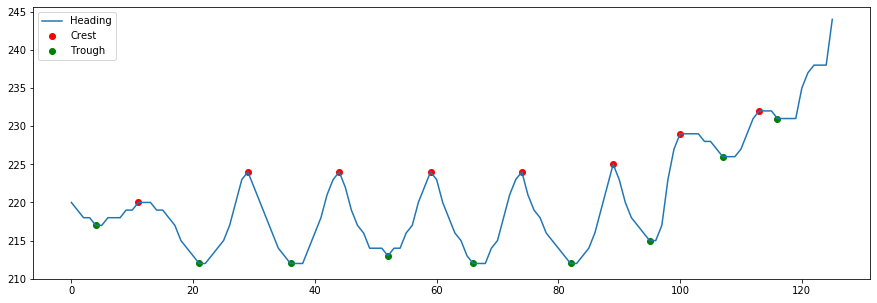

In [17]:
x = df[df["MMSI"]==248363000][["Heading"]].iloc[2448:2574]
x = find_peaks(x)

plt.figure(figsize=(15,5))
plt.plot(x["Heading"], label='Heading');
plt.scatter(x=x[x["C"]].index, y = x[x["C"]]["Heading"], color='red', label='Crest', );
plt.scatter(x=x[x["T"]].index, y = x[x["T"]]["Heading"], color='green', label='Trough');
plt.legend();

- The zig zag movement shall occur at higher frequency then only we can state that the ship is dragging.
- The time interval between the crest and trough shall be less 


In [56]:
p = x[x["C"]+x["T"]].copy()
p = p[::-1].reset_index()
p['diff'] = ((p["Heading"].diff(-1).abs() - p["Heading"].shift(-1).diff(-1).abs()).abs() <= 5).astype(int)
p["group"] = -1
p

index  Heading      C      T  diff  group
0     116    231.0  False   True     1     -1
1     113    232.0   True  False     1     -1
2     107    226.0  False   True     0     -1
3     100    229.0   True  False     1     -1
4      95    215.0  False   True     1     -1
5      89    225.0   True  False     1     -1
6      82    212.0  False   True     1     -1
7      74    224.0   True  False     1     -1
8      66    212.0  False   True     1     -1
9      59    224.0   True  False     1     -1
10     52    213.0  False   True     1     -1
11     44    224.0   True  False     1     -1
12     36    212.0  False   True     1     -1
13     29    224.0   True  False     1     -1
14     21    212.0  False   True     1     -1
15     11    220.0   True  False     0     -1
16      4    217.0  False   True     0     -1

In [59]:
import more_itertools as mit

for grp, dfx in p.groupby("diff"):
    print("-"*20)
    print(grp)
    print("-"*20)
    for i, grouped in enumerate(mit.consecutive_groups(dfx.index)):
        grp_label = (str(grp)+str(i))
        p['group'].iloc[list(grouped)] = grp_label
        
p

--------------------
0
--------------------
--------------------
1
--------------------


index  Heading      C      T  diff group
0     116    231.0  False   True     1    10
1     113    232.0   True  False     1    10
2     107    226.0  False   True     0    00
3     100    229.0   True  False     1    11
4      95    215.0  False   True     1    11
5      89    225.0   True  False     1    11
6      82    212.0  False   True     1    11
7      74    224.0   True  False     1    11
8      66    212.0  False   True     1    11
9      59    224.0   True  False     1    11
10     52    213.0  False   True     1    11
11     44    224.0   True  False     1    11
12     36    212.0  False   True     1    11
13     29    224.0   True  False     1    11
14     21    212.0  False   True     1    11
15     11    220.0   True  False     0    01
16      4    217.0  False   True     0    01

group the consecutive difference of heading with tolerance of 2 degrees 

use `more_itertools.mit`